# Определение стоимости автомобилей

## Содержание

1. Введение  
    1.1. Описание проекта  
    1.2. Описание данных  
2. Подготовка данных  
    2.1. Библиотеки  
    2.2. Загрузка и предобработка данных  
    2.3. Дубликаты и выбросы  
3. Обучение моделей  
    3.1. Линейная регрессия  
    3.2. Случайный лес  
    3.3. GBM  
4. Анализ моделей  

## Введение
### Описание проекта
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. 

**Задача:** построить модель для определения стоимости автомобиля по историческим данным: техническим характеристикам, комплектации и цены автомобилей.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Описание данных

**Признаки**  
- *DateCrawled* — дата скачивания анкеты из базы
- *VehicleType* — тип автомобильного кузова
- *RegistrationYear* — год регистрации автомобиля
- *Gearbox* — тип коробки передач
- *Power* — мощность (л. с.)
- *Model* — модель автомобиля
- *Kilometer* — пробег (км)
- *RegistrationMonth* — месяц регистрации автомобиля
- *FuelType* — тип топлива
- *Brand* — марка автомобиля
- *NotRepaired* — была машина в ремонте или нет
- *DateCreated* — дата создания анкеты
- *NumberOfPictures* — количество фотографий автомобиля
- *PostalCode* — почтовый индекс владельца анкеты (пользователя)
- *LastSeen* — дата последней активности пользователя

**Целевой признак**  
- *Price* — цена (евро)

## Подготовка данных

### Библиотеки

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
def train_valid_test_split(data, target_col_name):
    features = data.drop(target_col_name, axis=1)
    target = data[target_col_name]

    features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.2, random_state=123)

    features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=0.25, random_state=123)
    
    return features_train, features_valid, features_test, target_train, target_valid, target_test

### Загрузка и предобработка данных

In [3]:
data = pd.read_csv('autos.csv')
data.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data = data.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen'], 1)

In [6]:
data.columns= data.columns.str.lower()

data = data.rename(columns={'vehicletype': 'vehicle_type',
                            'registrationyear': 'registration_year',
                            'registrationmonth': 'registration_month',
                            'fueltype': 'fuel_type',
                            'notrepaired': 'not_repaired', 
                            'numberofpictures': 'number_of_pictures'})

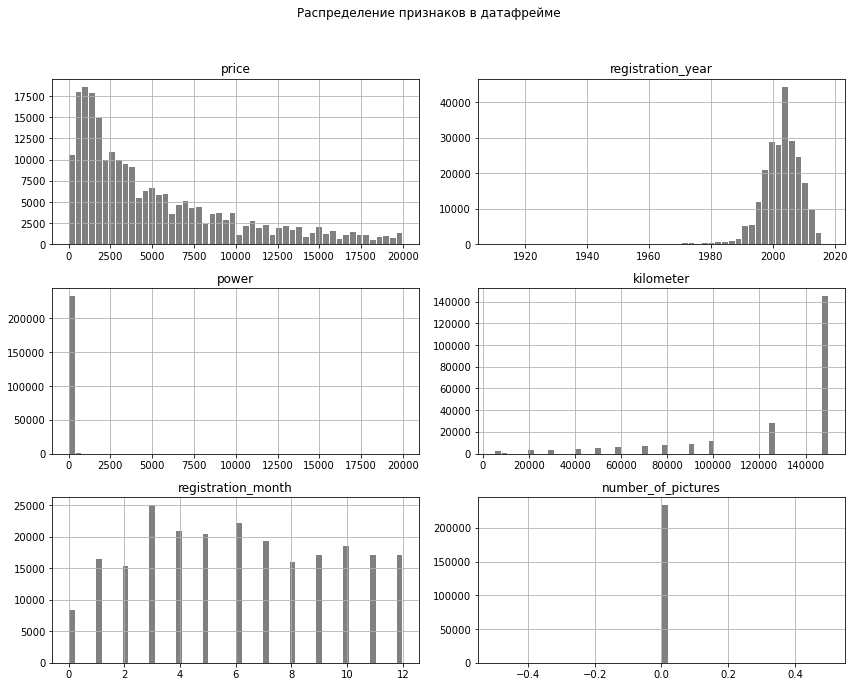

In [59]:
data.hist(bins=50, figsize=(12,10), color='grey', rwidth=0.85)
plt.suptitle('Распределение признаков в датафрейме');
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

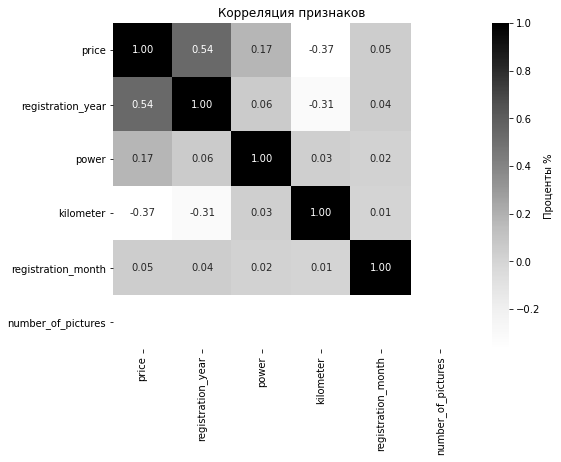

In [60]:
f, ax = plt.subplots(figsize=[8,6])
sns.heatmap(data.corr(),
            annot=True, fmt=".2f",cbar_kws={'label': 'Проценты %'},cmap="Greys",ax=ax)
ax.set_title('Корреляция признаков');

In [9]:
my_cols = data.columns.tolist()
for i in range(0, len(data.columns)):
    inx = data.columns[i]
    if inx in my_cols:
        a = data[data[inx].isnull()].shape[0]
        if a != 0:
            print('{: <15} {:>10.1%}'.format(inx, a/data.shape[0]))

vehicle_type         10.6%
gearbox               5.6%
model                 5.6%
fuel_type             9.3%
not_repaired         20.1%


In [10]:
zeros = len(data[data['price'] == 0])
print('Наблюдений с ценой = 0:', zeros, '->', round(zeros / len(data)*100, 2), '%')

Наблюдений с ценой = 0: 10772 -> 3.04 %


**Вывод**: В данных 354369 наблюдений, 16 признаков, признаки и числовые, и номинальные. Есть пропуски, больше всего - в столбцах с информациями о типе кузова (10%) и об отсутствии ремонта(20%).

Признаковые пространства отличаются по размерности, значит, нужно сделать масштабирование. Числовые признаки неколлинеарны.

### Дубликаты и выбросы
1) Удалим дубликаты.  
2) В данных есть наблюдения со странными годами выпуска автомобилей, например, 1000 или 9999. Это могут быть ошибки при заполнении таблицы, они повлияют на регрессию, удалим их, оставим только даты, которые могли бы быть реальными.

In [11]:
data = data.drop_duplicates()
data = data.query('registration_year > 1886 and registration_year <= 2021')

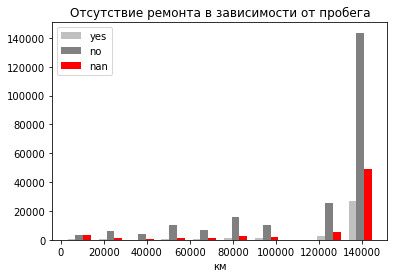

In [12]:
fig, ax = plt.subplots()
yes_heights, yes_bins = np.histogram(data[data['not_repaired'] == 'yes']['kilometer'])
no_heights, no_bins = np.histogram(data[data['not_repaired'] == 'no']['kilometer'], bins=yes_bins)
nan_heights, nan_bins = np.histogram(data[data['not_repaired'].isna()]['kilometer'], bins=yes_bins)
width = (yes_bins[1] - yes_bins[0])/4
ax.bar(yes_bins[:-1], yes_heights, width=width, facecolor='silver')
ax.bar(no_bins[:-1]+width, no_heights, width=width, facecolor='grey');
ax.bar(nan_bins[:-1]+width*2, nan_heights, width=width, facecolor='red');
ax.legend(['yes', 'no', 'nan']);
ax.set_xlabel('км')
ax.set_title('Отсутствие ремонта в зависимости от пробега');

Больше всего пропусков в колонке с информацией о том, не отправлялась ли машина на ремонт. По гистограмме видим, что с увеличением пробега ответов "нет" становится больше, но особенно это заметно на километрах = 150000. Заполним ответом "нет" пропуски в тех наблюдениях, где машина проехала 150000 километров.

In [13]:
def fill_not_repaired(km):
    if km < 150_000:
        return 'no'
    else:
        pass

In [14]:
data['not_repaired'] = data['not_repaired'].fillna(data['kilometer'].apply(fill_not_repaired))

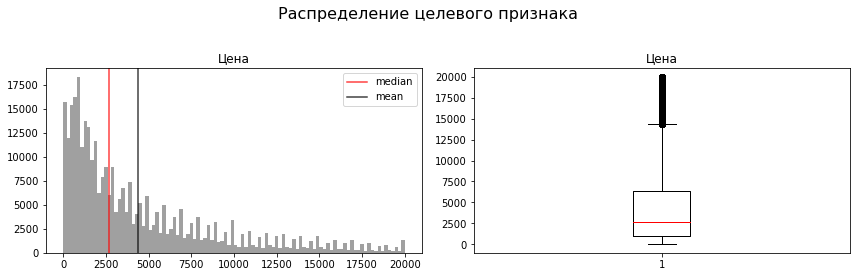

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax0, ax1 = axes.flatten()

ax0.hist(data['price'], bins=100, color='grey', alpha=0.75)
ax0.set_title('Цена');
price_median = data['price'].median()
price_mean = data['price'].mean()
ax0.axvline(x=price_median, color='red', alpha=0.75, label='median')
ax0.axvline(x=price_mean, color='black', alpha=0.75, label='mean')
ax0.legend();

ax1.boxplot(data['price'], medianprops=dict(color='red')) 
ax1.set_title('Цена');

fig.suptitle('Распределение целевого признака', fontsize=16);
fig.tight_layout(rect=[0, 0.03, 1, 0.95]);

In [16]:
# data = data.query('price > 500 and price < 15000')

В данных есть странные наблюдения с ценой = 0, а также есть выбросы выше 15000. Решено их не удалять (но не знаю, чем можно мотивировать это решение).

In [17]:
print(data.isnull().sum() * 100 / len(data))

price                  0.000000
vehicle_type          10.740733
registration_year      0.000000
gearbox                5.340366
power                  0.000000
model                  5.652002
kilometer              0.000000
registration_month     0.000000
fuel_type              9.489902
brand                  0.000000
not_repaired          14.960678
number_of_pictures     0.000000
dtype: float64


In [18]:
data = data.dropna()

**Вывод:** почистили данные от дубликатов и выбросов, заполнили некоторые пропуски в столбце о ремонте. Удалили все остальные пропуски, так как модели показывают лучший результат, если в данных нет пропусков.

## Обучение моделей

In [19]:
models_dict = {}

До обучения выполним следующее:

- Закодируем признаки типа object
- Выделим в данных целевую метку
- Разделим данные на обучающую и валидационную выборки
- Масштабируем признаки в обучающей и валидационной выборках

In [20]:
data_ohe = pd.get_dummies(data[['vehicle_type', 'gearbox', 'model', 
                                'fuel_type', 'brand', 'not_repaired']], drop_first=True)

data_num = data[['price', 'registration_year', 'power', 'kilometer', 
           'registration_month','number_of_pictures']]

ohe_encoded_data = pd.concat([data_ohe, data_num], axis=1)

In [21]:
(features_train, features_valid, features_test,
 target_train, target_valid, target_test) = train_valid_test_split(ohe_encoded_data, 'price')

for i in (features_train, features_valid, features_test, target_train, target_valid, target_test):
    print(i.shape)

(140130, 307)
(46711, 307)
(46711, 307)
(140130,)
(46711,)
(46711,)


In [22]:
numeric_to_scale = ['registration_year', 'power', 'kilometer',
                    'registration_month','number_of_pictures']

In [23]:
features_train_scaled = features_train.copy()
features_valid_scaled = features_valid.copy()
features_test_scaled = features_test.copy()

scaler = StandardScaler()
scaler.fit(features_train_scaled[numeric_to_scale])

features_train_scaled[numeric_to_scale] = scaler.transform(features_train_scaled[numeric_to_scale])

features_valid_scaled[numeric_to_scale] = scaler.transform(features_valid_scaled[numeric_to_scale])

features_test_scaled[numeric_to_scale] = scaler.transform(features_test_scaled[numeric_to_scale])

In [24]:
features_train_scaled.head(3)

,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_145,model_147,...,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_yes,registration_year,power,kilometer,registration_month,number_of_pictures
171260,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,1.288735,0.035265,-1.200303,-0.325609,0.0
104984,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,-0.762635,-0.035341,0.638948,0.817052,0.0
173188,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0.341949,-0.258926,-0.017927,-0.896940,0.0


In [25]:
features_valid_scaled.head(3)

,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_145,model_147,...,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_yes,registration_year,power,kilometer,registration_month,number_of_pictures
31398,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0.341949,-0.082411,0.638948,-0.611275,0.0
238439,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0.341949,0.182361,0.638948,-0.611275,0.0
126687,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,-0.131444,-0.323649,0.638948,1.102718,0.0


In [26]:
features_test_scaled.head(3)

,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,model_145,model_147,...,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_yes,registration_year,power,kilometer,registration_month,number_of_pictures
86803,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,-1.078230,0.182361,0.638948,1.102718,0.0
161886,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,-1.551623,0.182361,0.638948,0.245722,0.0
305661,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,-0.447039,-0.052992,-1.463053,0.245722,0.0


In [27]:
features_concatenated = pd.concat([features_train_scaled, features_valid_scaled])
target_concatenated = pd.concat([target_train, target_valid])

### Линейная регрессия
Обучим модель на тренировочной части выборки, проверим на валидационной, затем их объединим, дообучим модель и проверим на тестовой.

**train → valid**

In [28]:
start_time = time.time()
lin_model = LinearRegression().fit(features_train_scaled, target_train)
lin_train_time = time.time() - start_time

In [29]:
start_time = time.time()
lin_predicted = lin_model.predict(features_valid_scaled)
lin_pred_time = time.time() - start_time

In [30]:
lin_rmse = (mean_squared_error(target_valid, lin_predicted))**0.5
lin_list = [lin_rmse, lin_train_time, lin_pred_time]
models_dict['LinRegr Valid'] = lin_list

print('RMSE линейной регрессии на валидационной выборке', round(lin_rmse, 2))
print('Время обучения:', round(lin_train_time, 2))
print('Время предсказания', round(lin_pred_time, 2))

RMSE линейной регрессии на валидационной выборке 2778.18
Время обучения: 17.61
Время предсказания 0.44


**train + valid → test**

In [31]:
start_time_test = time.time()
lin_model_test = LinearRegression().fit(features_concatenated, target_concatenated)
lin_train_time_test = time.time() - start_time_test

In [32]:
start_time_test = time.time()
lin_predicted_test = lin_model_test.predict(features_test_scaled)
lin_pred_time_test = time.time() - start_time_test

In [33]:
lin_rmse_test = (mean_squared_error(target_test, lin_predicted_test))**0.5
lin_list_test = [lin_rmse_test, lin_train_time_test, lin_pred_time_test]
models_dict['LinRegr Test'] = lin_list_test

print('RMSE линейной регрессии на тестовой выборке', round(lin_rmse_test, 2))
print('Время обучения:', round(lin_train_time_test, 2))
print('Время предсказания', round(lin_pred_time_test, 2))

RMSE линейной регрессии на тестовой выборке 2781.46
Время обучения: 5.91
Время предсказания 0.11


### Случайный лес
Найдем пареметры на тренировочной части выборки, проверим на валидационной, затем их объединим, дообучим модель и проверим на тестовой.

In [34]:
def find_best_forest(features_train, target_train, features_valid, target_valid):
    best_model = None
    best_result = 10000
    best_est = 0
    best_depth = 0
    est_dict = {}
    
    for est in tqdm(range(20, 45, 5)):
        result_list = []
        for depth in range (15, 25, 1):
            model = RandomForestRegressor(random_state=123,
                                           n_estimators=est,
                                           max_depth=depth)
            model.fit(features_train, target_train)
            predicted = model.predict(features_valid)
            rmse = (mean_squared_error(target_valid, predicted))**0.5
            result_list.append(rmse)
            if rmse < best_result:
                best_model = model
                best_result = rmse
                best_est = est
                best_depth = depth
                
        est_dict[est] = result_list
    return best_model, best_result, best_est, best_depth, est_dict

In [35]:
# %%time
# (forest_model, forest_rmse,
# forest_est, forest_depth, 
#  forest_dict) = find_best_forest(features_train_scaled, target_train, 
#                      features_valid_scaled, target_valid)

# print('Оптимальное количество деревьев:', forest_est)
# print('Оптимальная глубина:', forest_depth)

# # Wall time: 1h 55min 4s

**train → valid**

In [36]:
start_time = time.time()
best_forest_model = RandomForestRegressor(random_state=123, n_estimators=40,
                                          max_depth=22).fit(features_train_scaled, target_train)
forest_train_time = time.time() - start_time

In [37]:
start_time = time.time()
forest_predicted = best_forest_model.predict(features_valid_scaled)
forest_pred_time = time.time() - start_time

In [38]:
forest_rmse = (mean_squared_error(target_valid, forest_predicted))**0.5
forest_list = [forest_rmse, forest_train_time, forest_pred_time]
models_dict['RandForest Valid'] = forest_list

print('RMSE случайного леса на валидационной выборке', round(forest_rmse, 2))
print('Время обучения:', round(forest_train_time, 2))
print('Время предсказания', round(forest_pred_time, 2))

RMSE случайного леса на валидационной выборке 1749.0
Время обучения: 131.47
Время предсказания 1.01


**train + valid → test**

In [39]:
start_time_test = time.time()
forest_model_test = RandomForestRegressor(random_state=123, n_estimators=40,
                                          max_depth=22).fit(features_concatenated, target_concatenated)
forest_train_time_test = time.time() - start_time_test

In [40]:
start_time_test = time.time()
forest_predicted_test = forest_model_test.predict(features_test_scaled)
forest_pred_time_test = time.time() - start_time_test

In [41]:
forest_rmse_test = (mean_squared_error(target_test, forest_predicted_test))**0.5
forest_list_test = [forest_rmse_test, forest_train_time_test, forest_pred_time_test]
models_dict['RandForest Test'] = forest_list_test

print('RMSE случайного леса на тестовой выборке', round(forest_rmse_test, 2))
print('Время обучения:', round(forest_train_time_test, 2))
print('Время предсказания', round(forest_pred_time_test, 2))

RMSE случайного леса на тестовой выборке 1735.61
Время обучения: 193.24
Время предсказания 0.96


### GBM

In [42]:
b_data = data.copy()
# b_data.info()

In [43]:
for c in b_data.columns:
    col_type = b_data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        b_data[c] = b_data[c].astype('category')

In [44]:
(b_features_train, b_features_valid, b_features_test,
 b_target_train, b_target_valid, b_target_test) = train_valid_test_split(b_data, 'price')

for i in (b_features_train, b_features_valid, b_features_test, 
          b_features_train, b_target_valid, b_target_test):
    print(i.shape)

(140130, 11)
(46711, 11)
(46711, 11)
(140130, 11)
(46711,)
(46711,)


In [45]:
b_features_concatenated = pd.concat([b_features_train, b_features_valid])
b_target_concatenated = pd.concat([b_target_train, b_target_valid])

In [46]:
lgb_train = lgb.Dataset(b_features_train, b_target_train, free_raw_data=False)
lgb_eval = lgb.Dataset(b_features_valid, b_target_valid, reference=lgb_train, free_raw_data=False)

lgb_concatenated = lgb.Dataset(b_features_concatenated, b_target_concatenated, free_raw_data=False)
lgb_test = lgb.Dataset(b_features_test, b_target_test, reference=lgb_train, free_raw_data=False)

In [47]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [48]:
num_train, num_feature = b_features_train.shape
feature_name = ['feature_' + str(col) for col in range(num_feature)]

**train → valid**

In [49]:
start_time = time.time()
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_eval,
                feature_name=feature_name,
                categorical_feature=[0, 2, 4, 7, 8, 9],
                verbose_eval=False)
gbm_train_time = time.time() - start_time

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [50]:
start_time = time.time()
gbm_predicted = gbm.predict(b_features_valid, num_iteration=gbm.best_iteration)
gbm_pred_time = time.time() - start_time

In [51]:
gbm_rmse = mean_squared_error(b_target_valid, gbm_predicted) ** 0.5
LightGBM_list = [gbm_rmse, gbm_train_time, gbm_pred_time]
models_dict['LightGBM Valid'] = LightGBM_list

print('RMSE LightGBM на валидационной выборке', round(gbm_rmse, 2))
print('Время обучения:', round(gbm_train_time, 2))
print('Время предсказания', round(gbm_pred_time, 2))

RMSE LightGBM на валидационной выборке 1679.22
Время обучения: 3.13
Время предсказания 0.49


**train + valid → test**

In [52]:
start_time = time.time()
gbm_test = lgb.train(params,
                     lgb_concatenated,
                     num_boost_round=200,
                     valid_sets=lgb_test,
                     feature_name=feature_name,
                     categorical_feature=[0, 2, 4, 7, 8, 9],
                     verbose_eval=False)
gbm_train_time_test = time.time() - start_time

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014021 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [53]:
start_time = time.time()
gbm_predicted_test = gbm_test.predict(b_features_test, num_iteration=gbm.best_iteration)
gbm_pred_time_test = time.time() - start_time

In [54]:
gbm_rmse_test = mean_squared_error(b_target_test, gbm_predicted_test) ** 0.5
LightGBM_list_test = [gbm_rmse_test, gbm_train_time_test, gbm_pred_time_test]
models_dict['LightGBM Test'] = LightGBM_list_test

print('RMSE LightGBM на валидационной выборке', round(gbm_rmse_test, 2))
print('Время обучения:', round(gbm_train_time_test, 2))
print('Время предсказания', round(gbm_pred_time_test, 2))

RMSE LightGBM на валидационной выборке 1693.87
Время обучения: 3.56
Время предсказания 0.5


## Анализ моделей

In [55]:
results_df = pd.DataFrame.from_dict(models_dict, 
                       orient='index', 
                       columns=['rmse', 'обучение', 'предсказание']).iloc[0:6].round(decimals=3)
results_df

,rmse,обучение,предсказание
LinRegr Valid,2778.184,17.612,0.444
LinRegr Test,2781.465,5.909,0.111
RandForest Valid,1749.005,131.467,1.007
RandForest Test,1735.609,193.236,0.962
LightGBM Valid,1679.220,3.134,0.488
LightGBM Test,1693.870,3.559,0.502


In [56]:
predictions = [pd.Series(lin_predicted), pd.Series(forest_predicted), pd.Series(gbm_predicted),
               pd.Series(lin_predicted_test), pd.Series(forest_predicted_test), pd.Series(gbm_predicted_test)]
titles = ['Линейная регрессия (valid)', 'Случайный лес (valid)','LightGBM (valid)',
          'Линейная регрессия (test)', 'Случайный лес (test)', 'LightGBM (test)']
rmses = [lin_rmse, forest_rmse, gbm_rmse,
         lin_rmse_test, forest_rmse_test, gbm_rmse_test]

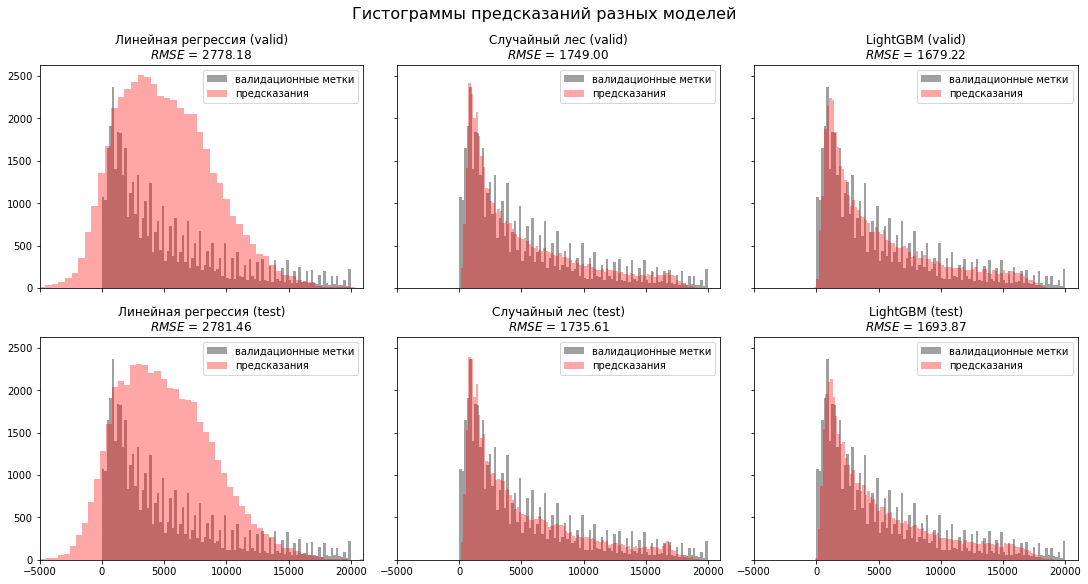

In [57]:
axs = plt \
.figure(figsize=(15, 8), constrained_layout=True) \
.subplots(2, 3, sharex=True, sharey=True) \
.flat

for ax, p, t, e in zip(axs, predictions, titles, rmses):
    ax.hist(target_valid, bins=100, alpha=.75, color='grey')
    ax.hist(p, bins=100, alpha=.35, color='red')
    ax.set_xlim(-5000, 21000)
    ax.legend(['валидационные метки', 'предсказания']);
    ax.set_title(str(t) + '\n$RMSE$ = {:.2f}'.format(e));

plt.suptitle('Гистограммы предсказаний разных моделей', fontsize=16);

Было обучено три модели: **Линейная регрессия**, **Случайный лес** и **LightGBM**. 

Самой быстрой, но в то же время самой неточной моделью для наших данных является **линейная регрессия**. Хотя ей на обучение и предсказание требуется около 15 и 0.07 секунд соответственно, её *RMSE* ~ 2774.  

Меньшая ошибка *RMSE* (1736.587) достигается при использовании **случайного леса**. Однако эта модель оказалась самой дорогой по времени. Чтобы подобрать лучшую глубину дерева и оптимальное количество деревьев, уходит от 40 минут до 2 часов. Обучение по выбранным параметрам занимает около 130.0 секунд, предсказание - 0.9.

Лучше всего себя показала **LightGBM**. При количестве итераций = 200 ее *RMSE* ниже, чем у леса (1679.098), обучение и предсказание занимают 13 и 0.9 секунд соответственно. При этом можно уменьшить время предсказания, если сократить количество итераций. Конечно, качество при этом тоже падает.